In [1]:
from expelliarmus import Wizard
import pathlib
import h5py
import numpy as np
import timeit
import requests

FIRST_RUN = False
REPEAT = 100

In [2]:
def get_diff_perc_str(ref, val):
    if (val > ref):
        return f"+{(val/ref-1)*100:.2f}%"
    else:
        return f"-{(1-val/ref)*100:.2f}%"
    
get_fsize_MB = lambda fpath: round(fpath.stat().st_size/(1024*1024))

In [3]:
if FIRST_RUN:
    # Downloading files.
    if not pathlib.Path("./spinner.dat").is_file():
        print("Downloading DAT file...")
        r = requests.get("https://dataset.prophesee.ai/index.php/s/YAri3vpPZHhEZfc/download", allow_redirects=True) # spinner.dat, DAT
        open('./spinner.dat', 'wb').write(r.content)
    if not pathlib.Path("./monitoring_40_50hz.raw").is_file():
        print("Downloading EVT2 file...")
        r = requests.get("https://dataset.prophesee.ai/index.php/s/s5DFqzVQhlaU8Y5/download", allow_redirects=True) # monitoring_40_50hz.raw, EVT2
        open('./monitoring_40_50hz.raw', 'wb').write(r.content)
    if not pathlib.Path("./driving_sample.raw").is_file():
        print("Downloading EVT3 file...")
        r = requests.get("https://dataset.prophesee.ai/index.php/s/nVcLLdWAnNzrmII/download", allow_redirects=True) # driving_sample.raw, EVT3
        open('./driving_sample.raw', 'wb').write(r.content)
    print("Everything downloaded!")
files = ("spinner.dat", "monitoring_40_50hz.raw", "driving_sample.raw")

In [4]:
softwares = ("expelliarmus", "hdf5", "hdf5_lzf", "hdf5_gzip", "numpy")
encodings = ("dat", "evt2", "evt3")
metrics = ("fsize", "full_read", "chunk_read")
data = {}
for software in softwares:
    data[software] = {}
    for encoding in encodings:
        data[software][encoding] = {}
        for metric in metrics:
            data[software][encoding][metric] = 0

In [5]:
wizard = Wizard(encoding="dat")
print("="*50+"\nFull file read")
for f, encoding in zip(files, encodings):
    print("="*50)

    exp_fpath = pathlib.Path(f)
    hdf5_fpath = pathlib.Path(f"./ref_HDF5_{encoding.upper()}.hdf5")
    hdf5_lzf_fpath = pathlib.Path(f"./ref_HDF5_LZF_{encoding.upper()}.hdf5")
    hdf5_gzip_fpath = pathlib.Path(f"./ref_HDF5_GZIP_{encoding.upper()}.hdf5")
    np_fpath = pathlib.Path(f"./ref_np_{encoding.upper()}.npy")

    wizard.set_encoding(encoding)
    wizard.set_file(exp_fpath)
    if FIRST_RUN:
        arr = wizard.read()
    data["expelliarmus"][encoding]["fsize"] = get_fsize_MB(exp_fpath)

    # HDF5 
    if FIRST_RUN:
        hdf5_fp = h5py.File(hdf5_fpath, "w")
        arr_hdf5 = hdf5_fp.create_dataset("arr", arr.shape, arr.dtype)
        arr_hdf5[:] = arr[:]
        hdf5_fp.close()
    data["hdf5"][encoding]["fsize"] = get_fsize_MB(hdf5_fpath)

    # HDF5 LZF
    if FIRST_RUN:
        hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath, "w")
        arr_hdf5_lzf = hdf5_lzf_fp.create_dataset("arr", arr.shape, arr.dtype, compression="lzf")
        arr_hdf5_lzf[:] = arr[:]
        hdf5_lzf_fp.close()
    data["hdf5_lzf"][encoding]["fsize"] = get_fsize_MB(hdf5_lzf_fpath)
    
    # HDF5 GZIP
    if FIRST_RUN:
        hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath, "w")
        arr_hdf5_gzip = hdf5_gzip_fp.create_dataset("arr", arr.shape, arr.dtype, compression="gzip")
        arr_hdf5_gzip[:] = arr[:]
        hdf5_gzip_fp.close()
    data["hdf5_gzip"][encoding]["fsize"] = get_fsize_MB(hdf5_gzip_fpath)
    
    # NumPy
    if FIRST_RUN:
        np.save(np_fpath, arr, allow_pickle=False)
    data["numpy"][encoding]["fsize"] = get_fsize_MB(np_fpath)

    data["expelliarmus"][encoding]["full_read"] = sum(timeit.repeat(lambda: wizard.read(), number=1, repeat=REPEAT))/REPEAT
    print(f'{encoding.upper()} ({data["expelliarmus"][encoding]["fsize"]}MB), execution time: {data["expelliarmus"][encoding]["full_read"]:.3f}s.')

    hdf5_fp = h5py.File(hdf5_fpath)
    data["hdf5"][encoding]["full_read"] = sum(timeit.repeat(lambda: hdf5_fp["arr"][:], number=1, repeat=REPEAT))/REPEAT
    print(f'HDF5 ({data["hdf5"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5"][encoding]["fsize"])}), execution time: {data["hdf5"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5"][encoding]["full_read"])}.')
    hdf5_fp.close()


    hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath)
    data["hdf5_lzf"][encoding]["full_read"] = sum(timeit.repeat(lambda: hdf5_lzf_fp["arr"][:], number=1, repeat=REPEAT))/REPEAT
    print(f'HDF5 LZF ({data["hdf5_lzf"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_lzf"][encoding]["fsize"])}), execution time: {data["hdf5_lzf"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5_lzf"][encoding]["full_read"])}.')
    hdf5_lzf_fp.close()

    hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath)
    data["hdf5_gzip"][encoding]["full_read"] = sum(timeit.repeat(lambda: hdf5_gzip_fp["arr"][:], number=1, repeat=REPEAT))/REPEAT
    print(f'HDF5 GZIP ({data["hdf5_gzip"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_gzip"][encoding]["fsize"])}), execution time: {data["hdf5_gzip"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["hdf5_gzip"][encoding]["full_read"])}.')
    hdf5_gzip_fp.close()

    data["numpy"][encoding]["full_read"] = sum(timeit.repeat(lambda: np.load(np_fpath), number=1, repeat=REPEAT))/REPEAT
    print(f'NumPy ({data["numpy"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["numpy"][encoding]["fsize"])}), execution time: {data["numpy"][encoding]["full_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["full_read"], data["numpy"][encoding]["full_read"])}.')

Full file read
DAT (413MB), execution time: 0.563s.
HDF5 (826MB, +100.00%), execution time: 0.445s, -20.95%.
HDF5 LZF (316MB, -23.49%), execution time: 1.921s, +241.25%.
HDF5 GZIP (163MB, -60.53%), execution time: 3.163s, +461.81%.
NumPy (826MB, +100.00%), execution time: 0.246s, -56.33%.
EVT2 (157MB), execution time: 0.522s.
HDF5 (621MB, +295.54%), execution time: 0.342s, -34.46%.
HDF5 LZF (276MB, +75.80%), execution time: 1.612s, +209.02%.
HDF5 GZIP (156MB, -0.64%), execution time: 2.744s, +425.97%.
NumPy (621MB, +295.54%), execution time: 0.130s, -75.18%.
EVT3 (350MB), execution time: 2.983s.
HDF5 (1701MB, +386.00%), execution time: 0.934s, -68.69%.
HDF5 LZF (746MB, +113.14%), execution time: 4.079s, +36.74%.
HDF5 GZIP (419MB, +19.71%), execution time: 7.438s, +149.34%.
NumPy (1701MB, +386.00%), execution time: 0.835s, -72.01%.


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('classic')
%matplotlib inline

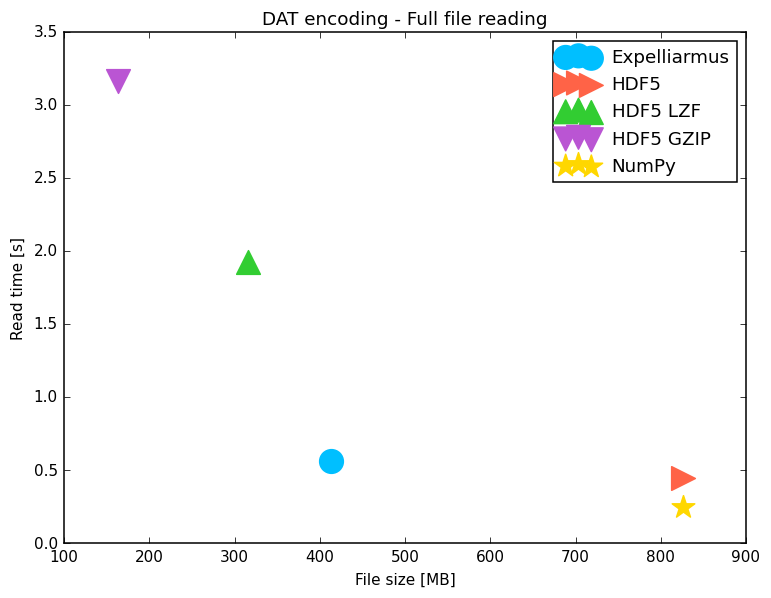

In [54]:
plt.figure(figsize=(8, 6), dpi=110)
plt.ylim(bottom=0, top=3.5)
plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("DAT encoding - Full file reading")

# Expelliarmus
exp = plt.scatter(data["expelliarmus"]["dat"]["fsize"], data["expelliarmus"]["dat"]["full_read"], marker="o", s=240, color="deepskyblue")

# HDF5
hdf5 = plt.scatter(data["hdf5"]["dat"]["fsize"], data["hdf5"]["dat"]["full_read"], marker=">", s=240, color="tomato")

# HDF5 LZF
hdf5_lzf = plt.scatter(data["hdf5_lzf"]["dat"]["fsize"], data["hdf5_lzf"]["dat"]["full_read"], marker="^", s=240, color="limegreen")

# HDF5 GZIP
hdf5_gzip = plt.scatter(data["hdf5_gzip"]["dat"]["fsize"], data["hdf5_gzip"]["dat"]["full_read"], marker="v", s=240, color="mediumorchid")

# NumPy
npy = plt.scatter(data["numpy"]["dat"]["fsize"], data["numpy"]["dat"]["full_read"], marker="*", s=240, color="gold")

plt.legend((exp, hdf5, hdf5_lzf, hdf5_gzip, npy), ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"), loc="upper right")
plt.show()

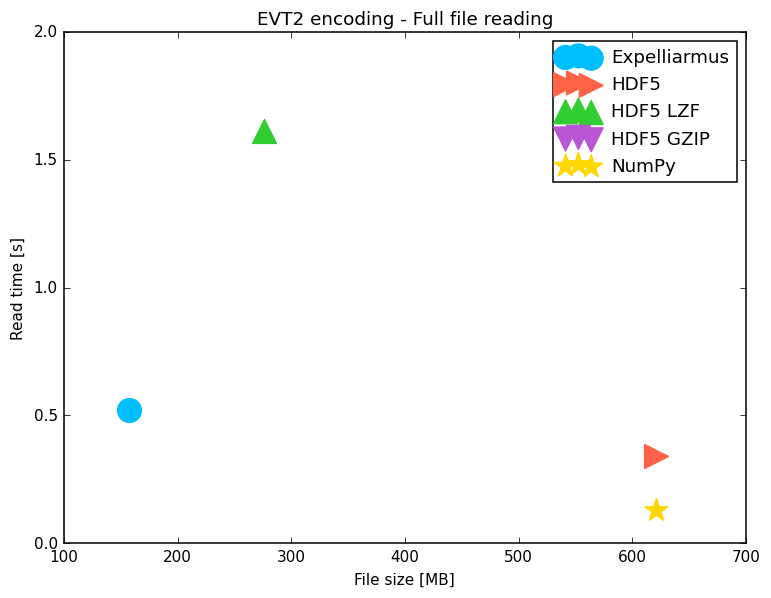

In [53]:
plt.figure(figsize=(8, 6), dpi=110)
plt.ylim(bottom=0, top=2)
plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("EVT2 encoding - Full file reading")

# Expelliarmus
exp = plt.scatter(data["expelliarmus"]["evt2"]["fsize"], data["expelliarmus"]["evt2"]["full_read"], marker="o", s=240, color="deepskyblue")

# HDF5
hdf5 = plt.scatter(data["hdf5"]["evt2"]["fsize"], data["hdf5"]["evt2"]["full_read"], marker=">", s=240, color="tomato")

# HDF5 LZF
hdf5_lzf = plt.scatter(data["hdf5_lzf"]["evt2"]["fsize"], data["hdf5_lzf"]["evt2"]["full_read"], marker="^", s=240, color="limegreen")

# HDF5 GZIP
hdf5_gzip = plt.scatter(data["hdf5_gzip"]["evt2"]["fsize"], data["hdf5_gzip"]["evt2"]["full_read"], marker="v", s=240, color="mediumorchid")

# NumPy
npy = plt.scatter(data["numpy"]["evt2"]["fsize"], data["numpy"]["evt2"]["full_read"], marker="*", s=240, color="gold")

plt.legend((exp, hdf5, hdf5_lzf, hdf5_gzip, npy), ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"), loc="upper right")
plt.show()

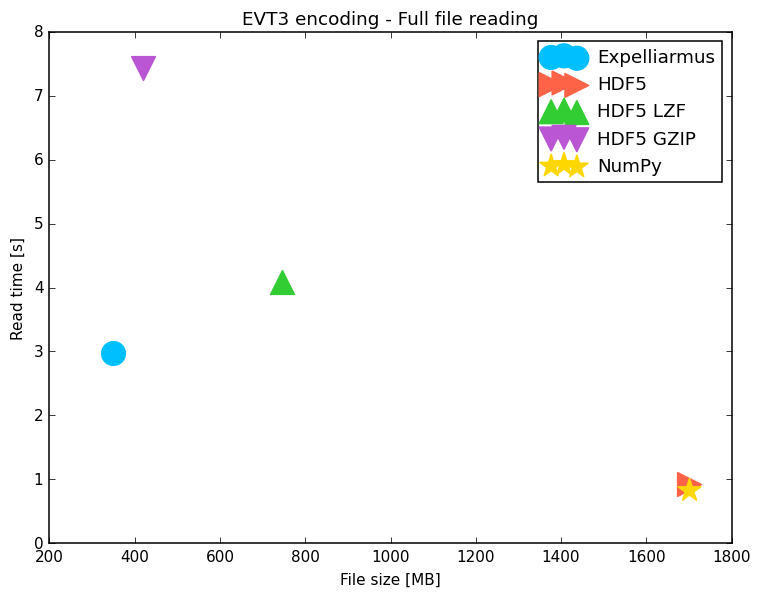

In [52]:
plt.figure(figsize=(8, 6), dpi=110)
plt.ylim(bottom=0, top=8)
plt.xlabel("File size [MB]")
plt.ylabel("Read time [s]")
plt.title("EVT3 encoding - Full file reading")

# Expelliarmus
exp = plt.scatter(data["expelliarmus"]["evt3"]["fsize"], data["expelliarmus"]["evt3"]["full_read"], marker="o", s=240, color="deepskyblue")

# HDF5
hdf5 = plt.scatter(data["hdf5"]["evt3"]["fsize"], data["hdf5"]["evt3"]["full_read"], marker=">", s=240, color="tomato")

# HDF5 LZF
hdf5_lzf = plt.scatter(data["hdf5_lzf"]["evt3"]["fsize"], data["hdf5_lzf"]["evt3"]["full_read"], marker="^", s=240, color="limegreen")

# HDF5 GZIP
hdf5_gzip = plt.scatter(data["hdf5_gzip"]["evt3"]["fsize"], data["hdf5_gzip"]["evt3"]["full_read"], marker="v", s=240, color="mediumorchid")

# NumPy
npy = plt.scatter(data["numpy"]["evt3"]["fsize"], data["numpy"]["evt3"]["full_read"], marker="*", s=240, color="gold")

plt.legend((exp, hdf5, hdf5_lzf, hdf5_gzip, npy), ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP", "NumPy"), loc="upper right")
plt.show()

In [40]:
CHUNK_SIZE = 8192
print("\n"+"="*50+"\nChunk reading.")
for f, encoding in zip(files, encodings):
    print("="*50)
    
    arr_len = len(np.load(f"ref_np_{encoding.upper()}.npy"))
    exp_fpath = pathlib.Path(f)
    hdf5_fpath = pathlib.Path(f"./ref_HDF5_{encoding.upper()}.hdf5")
    hdf5_lzf_fpath = pathlib.Path(f"./ref_HDF5_LZF_{encoding.upper()}.hdf5")
    hdf5_gzip_fpath = pathlib.Path(f"./ref_HDF5_GZIP_{encoding.upper()}.hdf5")
    
    wizard.set_encoding(encoding)
    wizard.set_file(exp_fpath)
    wizard.set_chunk_size(CHUNK_SIZE)
    def fn():
        wizard.reset()
        return [chunk for chunk in wizard.read_chunk()]

    data["expelliarmus"][encoding]["chunk_read"] = sum(timeit.repeat(fn, number=1, repeat=REPEAT))/REPEAT
    print(f'{encoding.upper()} ({data["expelliarmus"][encoding]["fsize"]}MB), execution time: {data["expelliarmus"][encoding]["chunk_read"]:.3f}s.')

    hdf5_fp = h5py.File(hdf5_fpath)
    data["hdf5"][encoding]["chunk_read"] = sum(timeit.repeat(lambda: [hdf5_fp["arr"][i*CHUNK_SIZE:min(arr_len, (i+1)*CHUNK_SIZE)] for i in range(arr_len//CHUNK_SIZE)], number=1, repeat=REPEAT))/REPEAT
    print(f'HDF5 ({data["hdf5"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5"][encoding]["fsize"])}), execution time: {data["hdf5"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5"][encoding]["chunk_read"])}.')

    hdf5_lzf_fp = h5py.File(hdf5_lzf_fpath)
    data["hdf5_lzf"][encoding]["chunk_read"] = sum(timeit.repeat(lambda: [hdf5_lzf_fp["arr"][i*CHUNK_SIZE:min(arr_len, (i+1)*CHUNK_SIZE)] for i in range(arr_len//CHUNK_SIZE)], number=1, repeat=REPEAT))/REPEAT
    print(f'HDF5 LZF ({data["hdf5_lzf"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_lzf"][encoding]["fsize"])}), execution time: {data["hdf5_lzf"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5_lzf"][encoding]["chunk_read"])}.')

    hdf5_gzip_fp = h5py.File(hdf5_gzip_fpath)
    data["hdf5_gzip"][encoding]["chunk_read"] = sum(timeit.repeat(lambda: [hdf5_gzip_fp["arr"][i*CHUNK_SIZE:min(arr_len, (i+1)*CHUNK_SIZE)] for i in range(arr_len//CHUNK_SIZE)], number=1, repeat=REPEAT))/REPEAT
    print(f'HDF5 GZIP ({data["hdf5_gzip"][encoding]["fsize"]}MB, {get_diff_perc_str(data["expelliarmus"][encoding]["fsize"], data["hdf5_gzip"][encoding]["fsize"])}), execution time: {data["hdf5_gzip"][encoding]["chunk_read"]:.3f}s, {get_diff_perc_str(data["expelliarmus"][encoding]["chunk_read"], data["hdf5_lzf"][encoding]["chunk_read"])}.')
    
    hdf5_fp.close()
    hdf5_lzf_fp.close()
    hdf5_gzip_fp.close()


Chunk reading.
DAT (413MB), execution time: 0.654s.
HDF5 (826MB, +100.00%), execution time: 2.572s, +293.03%.
HDF5 LZF (316MB, -23.49%), execution time: 5.629s, +760.15%.
HDF5 GZIP (163MB, -60.53%), execution time: 8.456s, +760.15%.
EVT2 (157MB), execution time: 0.514s.
HDF5 (621MB, +295.54%), execution time: 2.009s, +290.92%.
HDF5 LZF (276MB, +75.80%), execution time: 5.105s, +893.27%.
HDF5 GZIP (156MB, -0.64%), execution time: 8.670s, +893.27%.
EVT3 (350MB), execution time: 2.317s.
HDF5 (1701MB, +386.00%), execution time: 5.587s, +141.09%.
HDF5 LZF (746MB, +113.14%), execution time: 15.444s, +566.47%.
HDF5 GZIP (419MB, +19.71%), execution time: 25.576s, +566.47%.


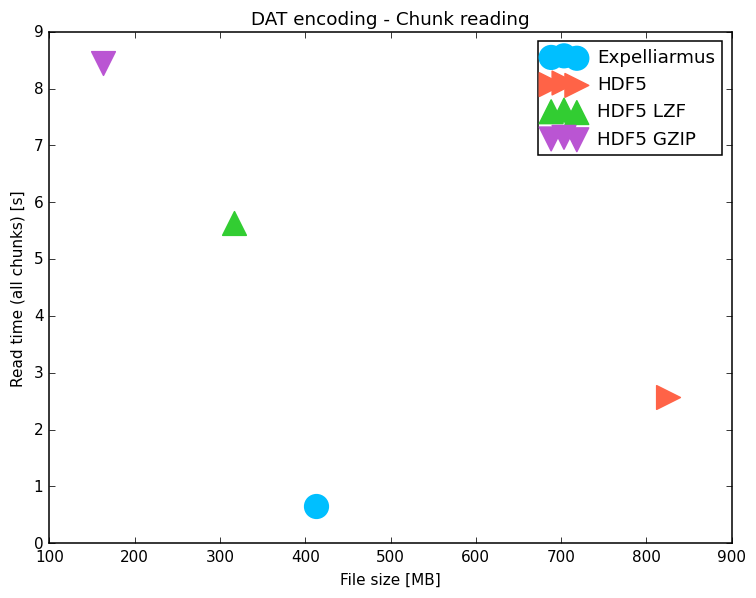

In [48]:
plt.figure(figsize=(8, 6), dpi=110)
plt.ylim(bottom=0, top=9)
plt.xlabel("File size [MB]")
plt.ylabel("Read time (all chunks) [s]")
plt.title("DAT encoding - Chunk reading")

# Expelliarmus
exp = plt.scatter(data["expelliarmus"]["dat"]["fsize"], data["expelliarmus"]["dat"]["chunk_read"], marker="o", s=240, color="deepskyblue")

# HDF5
hdf5 = plt.scatter(data["hdf5"]["dat"]["fsize"], data["hdf5"]["dat"]["chunk_read"], marker=">", s=240, color="tomato")

# HDF5 LZF
hdf5_lzf = plt.scatter(data["hdf5_lzf"]["dat"]["fsize"], data["hdf5_lzf"]["dat"]["chunk_read"], marker="^", s=240, color="limegreen")

# HDF5 GZIP
hdf5_gzip = plt.scatter(data["hdf5_gzip"]["dat"]["fsize"], data["hdf5_gzip"]["dat"]["chunk_read"], marker="v", s=240, color="mediumorchid")

plt.legend((exp, hdf5, hdf5_lzf, hdf5_gzip), ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP"), loc="upper right")
plt.show()

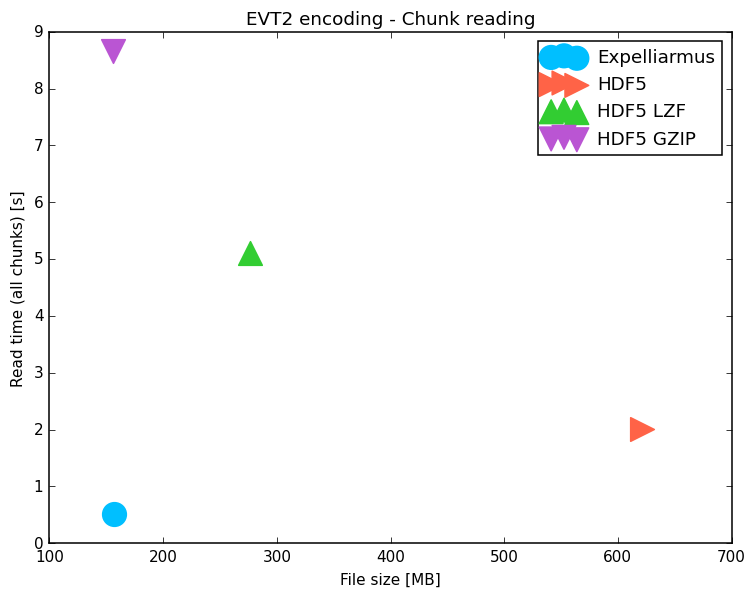

In [49]:
plt.figure(figsize=(8, 6), dpi=110)
plt.ylim(bottom=0, top=9)
plt.xlabel("File size [MB]")
plt.ylabel("Read time (all chunks) [s]")
plt.title("EVT2 encoding - Chunk reading")

# Expelliarmus
exp = plt.scatter(data["expelliarmus"]["evt2"]["fsize"], data["expelliarmus"]["evt2"]["chunk_read"], marker="o", s=240, color="deepskyblue")

# HDF5
hdf5 = plt.scatter(data["hdf5"]["evt2"]["fsize"], data["hdf5"]["evt2"]["chunk_read"], marker=">", s=240, color="tomato")

# HDF5 LZF
hdf5_lzf = plt.scatter(data["hdf5_lzf"]["evt2"]["fsize"], data["hdf5_lzf"]["evt2"]["chunk_read"], marker="^", s=240, color="limegreen")

# HDF5 GZIP
hdf5_gzip = plt.scatter(data["hdf5_gzip"]["evt2"]["fsize"], data["hdf5_gzip"]["evt2"]["chunk_read"], marker="v", s=240, color="mediumorchid")

plt.legend((exp, hdf5, hdf5_lzf, hdf5_gzip), ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP"), loc="upper right")
plt.show()

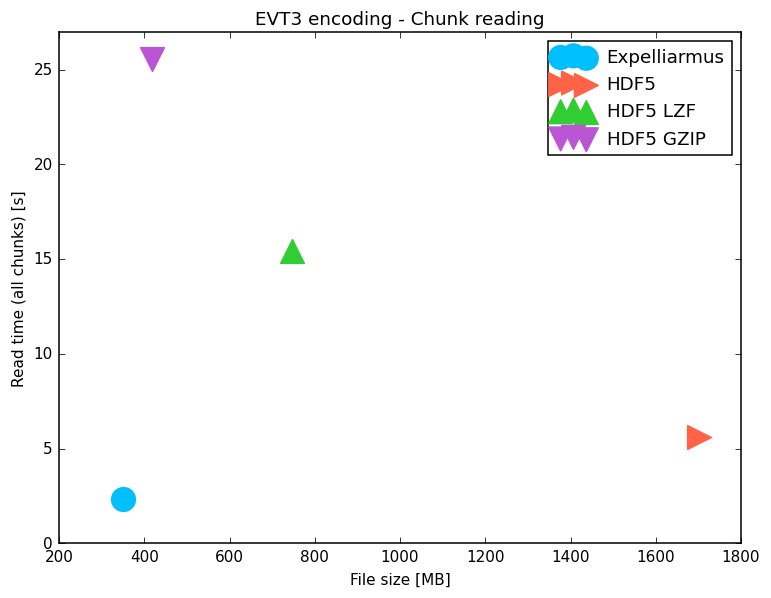

In [51]:
plt.figure(figsize=(8, 6), dpi=110)
plt.ylim(bottom=0, top=27)
plt.xlabel("File size [MB]")
plt.ylabel("Read time (all chunks) [s]")
plt.title("EVT3 encoding - Chunk reading")

# Expelliarmus
exp = plt.scatter(data["expelliarmus"]["evt3"]["fsize"], data["expelliarmus"]["evt3"]["chunk_read"], marker="o", s=240, color="deepskyblue")

# HDF5
hdf5 = plt.scatter(data["hdf5"]["evt3"]["fsize"], data["hdf5"]["evt3"]["chunk_read"], marker=">", s=240, color="tomato")

# HDF5 LZF
hdf5_lzf = plt.scatter(data["hdf5_lzf"]["evt3"]["fsize"], data["hdf5_lzf"]["evt3"]["chunk_read"], marker="^", s=240, color="limegreen")

# HDF5 GZIP
hdf5_gzip = plt.scatter(data["hdf5_gzip"]["evt3"]["fsize"], data["hdf5_gzip"]["evt3"]["chunk_read"], marker="v", s=240, color="mediumorchid")

plt.legend((exp, hdf5, hdf5_lzf, hdf5_gzip), ("Expelliarmus", "HDF5", "HDF5 LZF", "HDF5 GZIP"), loc="upper right")
plt.show()